In [1]:
#using DifferentialEquations
using Plots
using Statistics
using FFTW
FFTW.set_provider!("mkl")
#import Pkg; Pkg.add("FileIO")
using FileIO
using JLD2
using Base.Threads
using Distributions
#Pkg; Pkg.add("DistributedArrays")
println("nthreads = $(nthreads())")
using Printf
#import Pkg; Pkg.add("IJuliaBell")
using IJuliaBell
using ArraysOfArrays
using SummationByPartsOperators
using LinearAlgebra

nthreads = 10


## 2D PIC Escheleton 

Here we run the 2D version of PIC. 

In [2]:
include("aux_functions/aux_functions.jl")
include("aux_functions/inidat_aux_functions.jl")


f_x

### Initial Distribution

## Initial data configurations (Particles first)

In [3]:
## initial data configurations

trys = false
thermal = false
weibel = false
weibel_norel = false
damped = false
#trys = true
#thermal = true
weibel = true
#weibel_norel = true
#damped = true




true

In [4]:
const order = 5
const D = 2


# Particle numbers
const N_exp = 7 #5 #6 #7 #6 #7 #7#6#5 #6
N = 10^(N_exp)

if  thermal
    #run_name = "thermal_norel_"
    run_name = "thermal_rel_"
    #data_name = "par_dis_norel_thermal_"
    data_name = "par_dis_rel_thermal_"
    J = (50,50)
    Box_x = (0.0,1.0,0.0,1.0) 
    nm = [1,1]
    Box_array = [i for i in Box_x]
    k = 2π*nm./(Box_array[2:2:end]-Box_array[1:2:end-1]) # this here is k, not \hat{k}
    alpha_exp = 1 # 2 3 8
    α = 10.0^(-alpha_exp) # 0.1 0.001
    par_f_x = (α, nm, Box_x)
    exp_Theta = 3
    θ = 10.0^(-exp_Theta)
    p_max = sqrt((1+10*θ)^2-1)
    Box_p = (-p_max,p_max,-p_max,p_max)
    par_f_p = (θ,D)
    #par_f_p_1 = (θ,1,D) #to compute the norm of f_p
    #norm = int_mid_point_f(f_p_rel, par_f_p_1, [20_000,20_000], Box_p)
    #par_f_p_rel = (θ,norm,D)
    par_init = (α, nm)
    data_name = data_name * "nm_[$(nm[1]),$(nm[2])]_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box_x[2]-Box_x[1])x$(Box_x[4]-Box_x[3])_J_$(J[1])x$(J[2])_nm_[$(nm[1]),$(nm[2])]__Th$(exp_Theta)_alp$(alpha_exp)"
elseif weibel_norel
    run_name = "weibel_norel_"
    data_name = "par_dis_norel_weibel_"
    J = (100,100)
    Box_x = (0.0,1.0,0.0,1.0) 
    Ax = 1/2 # velocity anisotropy in the x direction
    alpha_exp = 8 # 8 so that is extremely small i.e. zero
    α = 10.0^(-alpha_exp) # 0.1 0.001
    par_f_x = (α, [0.0,0.0], Box_x)
    exp_Theta = 3
    θ = 10.0^(-exp_Theta)
    p_max = sqrt((1+10*θ)^2-1)
    Box_p = (-p_max,p_max,-p_max,p_max)
    par_f_p = (θ,D,Ax)
    par_init = (α, Ax)
    data_name = data_name * "Ax_(1d2)_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box_x[2]-Box_x[1])x$(Box_x[4]-Box_x[3])_J_$(J[1])x$(J[2])_Ax_(1d2)_Th$(exp_Theta)_alp$(alpha_exp)"
elseif weibel 
    run_name = "weibel_I2"
    #data_name = "par_dis_rel_weibel_"
    data_name = "par_dis_rel_weibel_MN_"
    J = (64,64)::NTuple{2,Int64} #no parece funcionar el dar el tipo NTuple, al menos no así.
    Box_x = (0.0,15.0,0.0,15.0) 
    Ax = 25 # velocity anisotropy in the x direction
    alpha_exp = 8 # 8 so that is extremely small i.e. zero
    α = 10.0^(-alpha_exp) # 0.1 0.001
    par_f_x = (α, [0.0,0.0], Box_x)
    exp_Theta = 3
    θ1 = 10.0^(-exp_Theta)
    θ2 = Ax * θ1
    p_max = 10*θ2
    Box_p = (-p_max,p_max,-p_max,p_max)
    par_init = (α, Ax)
    @show pars_f = (θ1,θ2,Ax)
    data_name = data_name * "Ax_$(Ax)_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box_x[2]-Box_x[1])x$(Box_x[4]-Box_x[3])_J_$(J[1])x$(J[2])_Ax_$(Ax)_Th$(exp_Theta)_alp$(alpha_exp)"
elseif damped
    run_name = "damped_I2_"
    data_name = "par_dis_rel_damped_"
    J = (930,100)::NTuple{2,Int64}
    Box_x = (0.0,7.455,0.0,1.0) # corner box coordinates
    Box_array = [i for i in Box_x]
    nm = [15,0] # wave numbers
    k = 2π*nm./(Box_array[2:2:end]-Box_array[1:2:end-1]) # this here is k, not \hat{k}
    alpha_exp = 2 # 3 8
    α = 10.0^(-alpha_exp) # 0.1, 0.01 0.001
    par_f_x = (α, nm, Box_x)
    exp_Theta = 3
    θ = 10.0^(-exp_Theta)
    p_max = sqrt((1+10*θ)^2-1) #maximum of the momentum box
    Box_p = (-p_max,p_max,-p_max,p_max)
    par_f_p = (θ,D)
    #par_f_p_1 = (θ,1,D) #to compute the norm of f_p
    #norm = int_mid_point_f(f_p_rel, par_f_p_1, [20_000,20_000], Box_p)
    #par_f_p_rel = (θ,norm,D)
    data_name = data_name * "nm_[$(nm[1]),$(nm[2])]_"
    data_name = data_name * "alp$(alpha_exp)_N$(N_exp)_Th$(exp_Theta)"
    run_name = run_name * "Box_$(Box_x[2]-Box_x[1])x$(Box_x[4]-Box_x[3])_J_$(J[1])x$(J[2])_Th$(exp_Theta)_alp$(alpha_exp)"
end



@show data_name 

# EVOLUTION PARAMETERS

exp_t = 0 #0# 1 #2
t = 0.0
t_i = 0.0
t_f = 4.0*10.0^(exp_t)
M = 201 #10001 #1001 #11 #16001# 4001 # 81 # 2001 # time steps 
M_g = 201 #8001 #400 + 1 #number of outputs, starting from the initial data
dx = differentials(Box_x,J)
@show dx_min = minimum(dx)
@show dt = (t_f-t_i)/(M-1)
@show CFL = dt/dx_min


# for plotting and other things
x_p = [dx[1]*(i-1) for i in 1:J[1]] ;
y_p = [dx[2]*(i-1) for i in 1:J[2]] ;

Dx = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box_x[1], xmax=Box_x[2], N=J[1])
Dy = periodic_derivative_operator(derivative_order=1, accuracy_order=6, xmin=Box_x[3], xmax=Box_x[4], N=J[2])
Δx = dissipation_operator(Dx;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
Δy = dissipation_operator(Dy;
                     #mode=D.coefficients.mode
                     #,mode=ThreadedMode()
                     )
const σx = 0.0 #1.0 #dissipation strength
const σy = 0.0 #1.0 #dissipation strength
dissipation = false
maxwell = true 

@show par_evolv = (t_i, t_f, M, M_g, dt)
@show par_grid = (N, J, Box_x, order)
#@show pars_f = (θ1,θ2,)



println("t_f = $(t_f), M = $M, dt = $(dt), exp_Theta = $(exp_Theta)")



run_name = run_name * "tf_$(convert(Int,10*t_f))_N$(N_exp)_M$(M)_o$(order)"
println(run_name)
println(data_name)


pars_f = (θ1, θ2, Ax) = (0.001, 0.025, 25)
data_name = "par_dis_rel_weibel_MN_Ax_25_alp8_N7_Th3"
dx_min = minimum(dx) = 0.234375
dt = (t_f - t_i) / (M - 1) = 0.02
CFL = dt / dx_min = 0.08533333333333333
par_evolv = (t_i, t_f, M, M_g, dt) = 

(0.0, 4.0, 201, 201, 0.02)
par_grid = (N, J, Box_x, order) = (10000000, (64, 64), (0.0, 15.0, 0.0, 15.0), 5)
t_f = 4.0, M = 201, dt = 0.02, exp_Theta = 3
weibel_I2Box_15.0x15.0_J_64x64_Ax_25_Th3_alp8tf_40_N7_M201_o5
par_dis_rel_weibel_MN_Ax_25_alp8_N7_Th3


In [5]:
par_dis, data_name, pars, par_f_x, Box_x, par_f_p, Box_p = retrieve_initial_data_D("Initial_Distributions/" * data_name * ".jld2")
#@show data_name_from_inidat, pars, par_f_x, Box_x, par_f_p, Box_p

([7.9666777974433485, 12.040651325394919, 0.044502970286418364, -0.016900444035837292, 14.52889807771196, 6.419675086930415, 0.03941823446506676, 0.0833846987936126, 10.120825765997049, 2.8658748517703865  …  -0.020883442665041996, -0.042216948618074124, 2.3543136772409605, 10.988461157145696, -0.08292099505503159, 0.07892509076420146, 1.5739876738340204, 3.351079163304689, 0.10032592390596001, 0.06040484803385232], "par_dis_rel_weibel_MN_Ax_25_alp8_N7_Th3", (10000000,), (1.0e-8, [0.0, 0.0], (0.0, 15.0, 0.0, 15.0)), (0.0, 15.0, 0.0, 15.0), (0.001, 0.025, [0.5, 0.0], 0.007760848597927437, 2), (-0.25, 0.25, -0.25, 0.25))

### Check Density

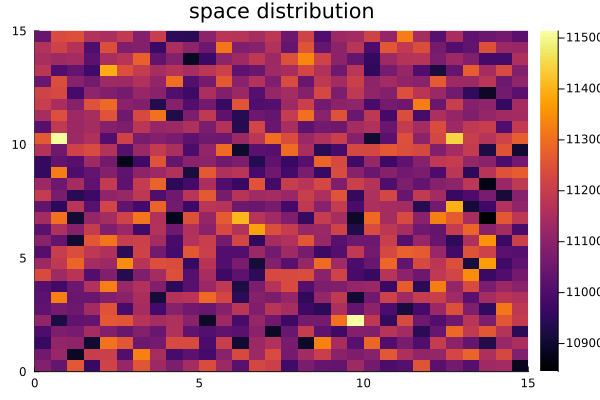

In [6]:
plot(histogram2d(par_dis[1:2D:end],par_dis[2:2D:end], title="space distribution", bins=50 ))

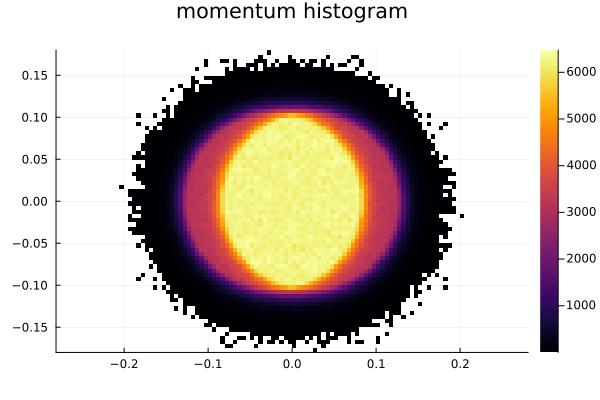

In [7]:
plot(histogram2d(par_dis[3:4:end],par_dis[4:4:end] )
,aspectratio=1
,title = "momentum histogram"
)

### Check Temperature

In [6]:
T = get_temperature_rel_D(par_dis,N,D)

0.0034931142430264044

In [7]:
#include("aux_functions/aux_functions.jl")
#par_grid = (N, Box_x, J, 5)
#n = zeros(J)
#get_density_2D!(par_dis, n, par_grid)

get_density_2D_trans = Density2DTrans(N, J)
n = get_density_2D_trans(Val(order), Box_x, par_dis);


In [ ]:
plot_matrix(n)

In [ ]:
plot(n[:,2])

### Check Normalization

In [8]:
sum(n)/prod(J)

1.0

### Check Current

In [9]:
par_grid = (N, J, Box_x, 5)
#S = [0.0::Float64 for l in 1:2, i in 1:J[1], j in 1:J[2]]
#S_new  = [0.0::Float64 for i in 1:J[1], j in 1:J[2], l in 1:2]
#TS = zeros(Float64,(2,J...,nthreads()))

#par_current_threads_S = (par_grid, TS)

#get_current_threads_2D!(par_dis, S, par_current_threads_S)
#S_new = get_current_2D_trans(Val(order), N, J, Box_x, par_dis)


get_current_2D_trans = Current2DTrans(N, J)
S = get_current_2D_trans(Val(order), Box_x, par_dis)
@show sum(S[:,:,1])

sum(S[:, :, 1]) = 9.71445146547012e-17


9.71445146547012e-17

In [ ]:
surface(y_p,x_p, S[:,:,1])

## Electric and Magnetic initial data

In [10]:
# We prescrive a constant magnetic field and the E is just a solution from Poisson's equations. 

B0 = 0.0 #initial magnetic field

B = [B0 for i in 1:J[1], j in 1:J[2]]

run_name = run_name * "_B0_$(convert(Int,trunc(B0)))"

"weibel_I2Box_15.0x15.0_J_64x64_Ax_25_Th3_alp8tf_40_N7_M201_o5_B0_0"

In [11]:
E = Array{Float64,3}(undef,(2,J...))
#ρ = n.-1.0/prod(J)
ρ = n.-1.0
@show sum(ρ)
get_E!(E,ρ,Box_x);

sum(ρ) = -6.650235917504688e-14


In [ ]:
surface(y_p,x_p, E[2,:,:])

In [ ]:
plot(x_p, E[1,:,5])

In [12]:
average_outputs = false # detailed output (for runs which are too long)
full_outputs = false
animation = false # to run animations
phase_space_show = false #show phase space diagrams
#phase_space_show = true
remote_server = false # if run in remote_server as a script avoid all plots 
save_plots = false # put true is you want so save your plots.
#full_outputs = true
average_outputs = true
#animation = true

true

We build the initial data:

In [13]:
u = Vector{Float64}(undef, 4N + 3*prod(J)); # contains r, v and E and B

du = Vector{Float64}(undef, 4N + 3*prod(J)); # contains r, v and E

u[1:4N] = par_dis 

Fu = view(u,4N+1:4N+3*prod(J))

F = reshape(Fu,3,J...)

#F = view(u[4N+1:end],3,J...)
F[1:2,:,:] = E
F[3,:,:] = B;

# the total electric energy is:

(norm(E)^2 + norm(B)^2)*prod(dx)
#u
#F[3,:,:]



0.0021983634400135014

In [ ]:
#surface(y_p,x_p,F[1,:,:])

In [14]:
Energy_Ks, Energy_Es = get_energy_rel(u,(Box_x, N, J))

(0.7839701946278127, 0.0010991817200067507)

In [ ]:
#surface(y_p,x_p,F[3,:,:])

In [15]:
u[4N+2*prod(J)+1:end]
#u[4N+1:end-prod(J)]

4096-element Vector{Float64}:
  0.0
  0.0013918691325723956
 -0.0012416294461422596
  0.0
  0.0013150550760043457
 -0.001244502927421876
  0.0
  0.002468232494616588
 -0.0006185020474755057
  0.0
  ⋮
 -0.0012799871697970159
 -0.0020380733685092323
  0.0
 -0.000495056882837485
 -0.0034511578144604724
  0.0
  0.0012124091059042194
 -0.0035002736630603973
  0.0

With the particle distribution we construct the initial data for the electric field. For that first we compute de density, using different types of particles (order).

### What follows are characterizations of the initial data properties.

In [16]:

Coordinate_test(u,Box_x,N)

#println("n_total = $(sum(n .- 1.0))")
#println("v_total = $(sum(u[N+1:2N]))")
#println("E_total = $(sum(E_i))")

#println("S_total = $(sum(S))")

test passed


## TIME Evolution: 

Now we make the time evolution:

1. we define parameters and vectors where to upload data to study the time evolution: Kinetic Energy, Electric field Energy, Total Electric field, total velocity (momentum), total density, total charge current.

2. we save a vector with the particle phase space, this can be a lot of memory!

In [17]:

if nthreads() > 1
#TS = zeros(Float64, (2,J...,nthreads()))
#p_RHS_D = (N, J, Box_x, order, n, S, du, get_density_2D!, get_current_threads_2D!, Interpolate_EBv_1, TS, Dx, Δx, σx, Dy, Δy, σy) ;
p_RHS_D_slim = (order, N, J, Box_x, order, n, S, du, get_density_2D!, get_current_slim, Interpolate_All_EBv_2_slim, Dx, Δx, σx, Dy, Δy, σy, maxwell, dissipation) ;
else
p_RHS_D = (N, J, Box_x, order, n, S, du, get_density_2D!, get_current_rel_2D!, Interpolate_EBv_1, Dx, Δx, σx, Dy, Δy, σy, maxwell, dissipation) ;
end


(5, 10000000, (64, 64), (0.0, 15.0, 0.0, 15.0), 5, [0.9965104191253595 0.9792861670732617 … 0.9936395526121341 1.004869882233653; 1.0002411198732402 0.99766339651191 … 0.9915939925350133 0.9947211191933883; … ; 0.984728475340107 0.9868092994342208 … 1.007617458873863 0.9915458903552913; 0.9878750452481035 0.9835310492331848 … 0.9986720497358078 0.993375659543507], [0.0009394500480744009 -7.131030290472408e-5 … -0.00033171169926510155 0.0006828758416852179; 0.001004211758082871 -0.00010087984928742153 … 2.6263956444512587e-6 0.0006693113920942538; … ; -0.000753311495311535 -0.0008042980912002891 … -0.0012995981299247555 -0.0009899747748162984; -0.0008075477587441619 -0.000960393970780374 … 0.00021121163166030964 0.00033890395125051;;; -0.000529850657107633 0.00011736287295073618 … -0.0006444486456542452 6.848433252908016e-5; -0.0005836588104695099 1.1655307056494393e-5 … -0.00015806143648984262 3.378113797461705e-5; … ; 0.0003788118161528042 0.0006038458832156833 … -0.000729323185905009

In [18]:
t = 0.0
j = 1

run_pars = Dict("run_name" => run_name, "par_grid" => par_grid, "par_evolv" => par_evolv, "p_Ini" => (par_f_x, par_f_p))

if full_outputs
    run_name = run_name * "_full"
elseif average_outputs
    run_name = run_name * "_ave"
end

file_name = "Results/"* run_name * ".jld2"
#rm(file_name)




save(file_name, run_pars)

if false # solo para testear
file = jldopen(file_name, "r+")
close(file)
end

if full_outputs
    field_name = "u"
    tiempo = @sprintf("%05d", j)
    jldopen(file_name, "a+") do file
        file[field_name * "/u_$(tiempo)"] = u;
    end
end

if average_outputs
    load_averages_D(file_name, j, par_grid, pars_f)
end

if animation
    par = Array{Float64,2}(undef,M_g,length(u));
    par[1,:] = u[:]
end

In [19]:
@show file_name
@show full_outputs
@show average_outputs


file_name = "Results/weibel_I2Box_15.0x15.0_J_64x64_Ax_25_Th3_alp8tf_40_N7_M201_o5_B0_0_ave.jld2"
full_outputs = false
average_outputs = true


true

In [26]:
par_grid

(10000000, (64, 64), (0.0, 15.0, 0.0, 15.0), 5)

In [ ]:
#RHS_D(u,t,p_RHS_D)

In [30]:
#include("aux_functions/aux_functions.jl")
for k in 2:M
  RK4_Step!(RHS_D_slim!,u,t,dt,p_RHS_D_slim)
  #global u = [make_periodic!(u[1:4N],Box_x); u[4N+1:end]]
  # make_periodic!(u,Box_x,N) # done inside the RHS_D function at every RK step
  #filter_constant!(u[2N+1:end])
  global t = t + dt
  if (k-1) % (M÷(M_g-1)) == 0
    local j = (k-1)÷(M÷(M_g-1))+1
    make_periodic!(u,Box_x,N) # just to save the correct data
    global Energy_Ks, Energy_Es = get_energy_rel(u,(Box_x, N, J))

    if average_outputs
      load_averages_D(file_name, j, par_grid, pars_f)
    end

    if full_outputs
        local tiempo = @sprintf("%05d", j)
        jldopen(file_name, "a+") do file
            file[field_name * "/u_$(tiempo)"] = u
      end
    end

    println("j = $j , t = $t, k = $k, nthreads = $(nthreads()), Total_Energy = $(Energy_Ks + Energy_Es), E_Energy = $(Energy_Es)")

    if animation
      par[j,:] = u[:]
    end
  end
end

j = 2 , t = 0.02, k = 2, nthreads = 10, Total_Energy = 0.7850693031486572, E_Energy = 0.0010979180026600415


j = 3 , t = 0.04, k = 3, nthreads = 10, Total_Energy = 0.7850692392797937, E_Energy = 0.0010962244834846451


j = 4 , t = 0.06, k = 4, nthreads = 10, Total_Energy = 0.7850691570170567, E_Energy = 0.001093825358777857


j = 5 , t = 0.08, k = 5, nthreads = 10, Total_Energy = 0.785069056104745, E_Energy = 0.0010907232522137324


j = 6 , t = 0.1, k = 6, nthreads = 10, Total_Energy = 0.7850689362188016, E_Energy = 0.0010869215986671443


j = 7 , t = 0.12000000000000001, k = 7, nthreads = 10, Total_Energy = 0.7850687969779784, E_Energy = 0.001082424658353696


j = 8 , t = 0.14, k = 8, nthreads = 10, Total_Energy = 0.7850686379549091, E_Energy = 0.0010772375331803896


j = 9 , t = 0.16, k = 9, nthreads = 10, Total_Energy = 0.7850684586877166, E_Energy = 0.0010713661847615496


j = 10 , t = 0.18, k = 10, nthreads = 10, Total_Energy = 0.7850682586953536, E_Energy = 0.0010648174534918897


j = 11 , t = 0.19999999999999998, k = 11, nthreads = 10, Total_Energy = 0.7850680374916001, E_Energy = 0.0010575990780226055


j = 12 , t = 0.21999999999999997, k = 12, nthreads = 10, Total_Energy = 0.7850677946004095, E_Energy = 0.0010497197144582425


j = 13 , t = 0.23999999999999996, k = 13, nthreads = 10, Total_Energy = 0.7850675295710904, E_Energy = 0.0010411889545824738


j = 14 , t = 0.25999999999999995, k = 14, nthreads = 10, Total_Energy = 0.7850672419930587, E_Energy = 0.0010320173424289204


j = 15 , t = 0.27999999999999997, k = 15, nthreads = 10, Total_Energy = 0.7850669315099772, E_Energy = 0.001022216388538185


j = 16 , t = 0.3, k = 16, nthreads = 10, Total_Energy = 0.7850665978337605, E_Energy = 0.0010117985812833584


j = 17 , t = 0.32, k = 17, nthreads = 10, Total_Energy = 0.7850662407559846, E_Energy = 0.001000777394701741


j = 18 , t = 0.34, k = 18, nthreads = 10, Total_Energy = 0.7850658601586532, E_Energy = 0.0009891672923383027


j = 19 , t = 0.36000000000000004, k = 19, nthreads = 10, Total_Energy = 0.7850654560232552, E_Energy = 0.0009769837266842107


j = 20 , t = 0.38000000000000006, k = 20, nthreads = 10, Total_Energy = 0.7850650284380498, E_Energy = 0.0009642431338793671


j = 21 , t = 0.4000000000000001, k = 21, nthreads = 10, Total_Energy = 0.7850645776021912, E_Energy = 0.0009509629234384814


j = 22 , t = 0.4200000000000001, k = 22, nthreads = 10, Total_Energy = 0.7850641038298795, E_Energy = 0.0009371614628532673


j = 23 , t = 0.4400000000000001, k = 23, nthreads = 10, Total_Energy = 0.7850636075507046, E_Energy = 0.0009228580570171243


j = 24 , t = 0.46000000000000013, k = 24, nthreads = 10, Total_Energy = 0.7850630893083299, E_Energy = 0.0009080729225106745


j = 25 , t = 0.48000000000000015, k = 25, nthreads = 10, Total_Energy = 0.785062549757848, E_Energy = 0.000892827156874404


j = 26 , t = 0.5000000000000001, k = 26, nthreads = 10, Total_Energy = 0.7850619896610287, E_Energy = 0.0008771427030768669


j = 27 , t = 0.5200000000000001, k = 27, nthreads = 10, Total_Energy = 0.7850614098789096, E_Energy = 0.0008610423094616279


j = 28 , t = 0.5400000000000001, k = 28, nthreads = 10, Total_Energy = 0.7850608113641943, E_Energy = 0.000844549485522352


j = 29 , t = 0.5600000000000002, k = 29, nthreads = 10, Total_Energy = 0.7850601951521464, E_Energy = 0.0008276884539120922


j = 30 , t = 0.5800000000000002, k = 30, nthreads = 10, Total_Energy = 0.7850595623496913, E_Energy = 0.0008104840991389293


j = 31 , t = 0.6000000000000002, k = 31, nthreads = 10, Total_Energy = 0.7850589141241533, E_Energy = 0.0007929619134351547


j = 32 , t = 0.6200000000000002, k = 32, nthreads = 10, Total_Energy = 0.7850582516914503, E_Energy = 0.0007751479403120088


j = 33 , t = 0.6400000000000002, k = 33, nthreads = 10, Total_Energy = 0.7850575763047956, E_Energy = 0.0007570687163255454


j = 34 , t = 0.6600000000000003, k = 34, nthreads = 10, Total_Energy = 0.7850568892414178, E_Energy = 0.0007387512115815698


j = 35 , t = 0.6800000000000003, k = 35, nthreads = 10, Total_Energy = 0.7850561917913562, E_Energy = 0.0007202227694999033


j = 36 , t = 0.7000000000000003, k = 36, nthreads = 10, Total_Energy = 0.7850554852462573, E_Energy = 0.0007015110463411058


j = 37 , t = 0.7200000000000003, k = 37, nthreads = 10, Total_Energy = 0.7850547708879413, E_Energy = 0.0006826439509727826


j = 38 , t = 0.7400000000000003, k = 38, nthreads = 10, Total_Energy = 0.7850540499793869, E_Energy = 0.0006636495853187824


j = 39 , t = 0.7600000000000003, k = 39, nthreads = 10, Total_Energy = 0.7850533237548307, E_Energy = 0.0006445561858939615


j = 40 , t = 0.7800000000000004, k = 40, nthreads = 10, Total_Energy = 0.7850525934130105, E_Energy = 0.0006253920667809711


j = 41 , t = 0.8000000000000004, k = 41, nthreads = 10, Total_Energy = 0.7850518601095245, E_Energy = 0.0006061855643548588


j = 42 , t = 0.8200000000000004, k = 42, nthreads = 10, Total_Energy = 0.7850511249525636, E_Energy = 0.0005869649840075469


In [ ]:
j = 11

Plots.scatter(par[j,1:2D:4N], par[j,2:2D:4N], ts=0.2
, thickness_scaling = 0.3
, markersize = 0.3
, title = "space", legend =:false)

#png("weibel_space_t=10")

In [ ]:
#include("aux_functions/aux_functions.jl")


#make_periodic!(par[M_g,:],Box_x,N)
Coordinate_test(par[M_g,:],Box_x,N)

In [ ]:
j = 11

histogram2d(par[j,1:2D:4N], par[j,2:2D:4N], ts=0.2
, thickness_scaling = 0.3
, markersize = 0.3
, title = "space", legend =:false)

In [ ]:
j = 11
Plots.scatter(par[j,3:2D:4N], par[j,4:2D:4N], ts=0.2
, thickness_scaling = 0.3
, markersize = 0.3
, title = "momentum", legend =:false)

#png("weibel_momentum_t=10")

In [ ]:
j = M_g
Fuj = view(par[j,:],4N+1:4N+3*prod(J))

Fj = reshape(Fuj,3,J...)

#F = view(u[4N+1:end],3,J...)
Ej = Fj[1:2,:,:]
Bj = Fj[3,:,:];

#surface(y_p,x_p,Ej[2,:,:])
#surface(y_p,x_p,Bj[:,:])

#norm(Bj)

In [ ]:
plot(Ej[1,:,50])
plot!(Bj[:,50])

In [ ]:
l = 1
P = 5
plot()
for j in 1:M_g
    Fuj = view(par[j,:],4N+1:4N+3*prod(J))
    Fj = reshape(Fuj,3,J...)
    Ej = Fj[1:2,:,:]
    Bj = Fj[3,:,:];
    plot!(Ej[l,:,P])
    plot!(Bj[:,P])
end
plot!(legend=false)

In [ ]:
norm(par[1,4N+1:4N+3*prod(J)] - par[11,4N+1:4N+3*prod(J)])/norm(par[1,4N+1:4N+3*prod(J)])

### Momentum rotation

### Constraint cheking

In [ ]:
j = M_g
par_grid = (N, Box_x, J, 5)

#nf = get_density_2D_trans(Val(order), Box_x, par[j,1:4N])

#Ef = Array{Float64,3}(undef,(2,J...))
#ρf = nf.-1.0/prod(J)
#ρf = nf .-1.0
#@show sum(ρf)
#get_E!(Ef,ρf,Box_x);

Fuj = view(par[j,:],4N+1:4N+3*prod(J))
Fj = reshape(Fuj,3,J...)
#F = view(u[4N+1:end],3,J...)
Ej = Fj[1:2,:,:]
@show(norm(Ej))

#### They do not coincide because there are waves starting. But the weak form of the constraints is satisfied, as we shall see below.

In [ ]:
nf = get_density_2D_trans(Val(order), Box_x, par[M_g,1:4N])
ρf = nf .-1.0;

In [ ]:
#include("aux_functions/aux_functions_E-B.jl")
x0=[Box_x[1] + (Box_x[2]-Box_x[1])*rand(), Box_x[3] + (Box_x[4]-Box_x[3])*rand()]
@show x0
pars = (x0, 0.2, 6)
constraint_test(Ej, ρf, J, Box_x, ϕ_test, ∇ϕ_test, pars)

In [ ]:
Err = 0.0
Max = 0.0
M = 100
for i in 1:M
    x0=[Box_x[1] + (Box_x[2]-Box_x[1])*rand(), Box_x[3] + (Box_x[4]-Box_x[3])*rand()]
    pars = (x0, 0.2, 6)
    div, rho, err = constraint_test(Ej, ρf, J, Box_x, ϕ_test, ∇ϕ_test, pars)
    Err = Err + abs(err)
    if err > Max
        @show Max = err
        @show x0
    end
    
end
@show Err/M
@show Max;